## SF crime from 2010 to 2021 data analysis and modeling
Import data from (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry)

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
dbutils.library.installPyPI("geopandas")
import geopandas as gpd
import seaborn as sns

import os
os.environ["PYSPARK_PYTHON"] = "python3"


dbutils.library APIs are deprecated and will be removed in a future DBR release. You can use %pip and %conda commands to install notebook scoped python libraries. For more information see https://docs.databricks.com/libraries/notebooks-python-libraries.html.
PyPI package geopandas has been installed already. The previously installed package is `geopandas`. To resolve this issue, detach and re-attach the notebook to create a new environment or rename the package.

In [0]:
import urllib.request
urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/myxxxx.csv")
dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/jxchen/spark/data/sf_03_18.csv")
data_path = "dbfs:/jxchen/spark/data/sf_03_18.csv"

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.format("csv").option("header", "true").load(data_path)
df.createOrReplaceTempView('sf_crime')

In [0]:
print("Shape of the data ", (df.count(), len(df.columns)))

Shape of the data (2129525, 35)

####Count the number of crimes for different category and visulize the result

In [0]:
crimeCategory = df.groupBy('Category').count().orderBy('count', ascending=False)
crimeCategory = crimeCategory.toPandas()
crimeCategory

Out[224]:

,Category,count
0,LARCENY/THEFT,477975
1,OTHER OFFENSES,301874
2,NON-CRIMINAL,236928
3,ASSAULT,167042
4,VEHICLE THEFT,126228
5,DRUG/NARCOTIC,117821
6,VANDALISM,114718
7,WARRANTS,99821
8,BURGLARY,91067
9,SUSPICIOUS OCC,79087


As the output above, larceny has the most number of crimes.

####Analyze the number of crime in each month from 2003 to 2017 (the data does not cover whole year of 2018).

In [0]:
crimeMonth = spark.sql('select left(Date, 2) as Month, count(*) as Count from sf_crime where right(Date, 4) < 2018 group by 1 order by 1')
crimeMonth = crimeMonth.toPandas()
crimeMonth

Out[233]:

,Month,Count
0,01,178056
1,02,161560
2,03,179035
3,04,172294
4,05,176420
5,06,168232
6,07,175525
7,08,181183
8,09,176413
9,10,183034


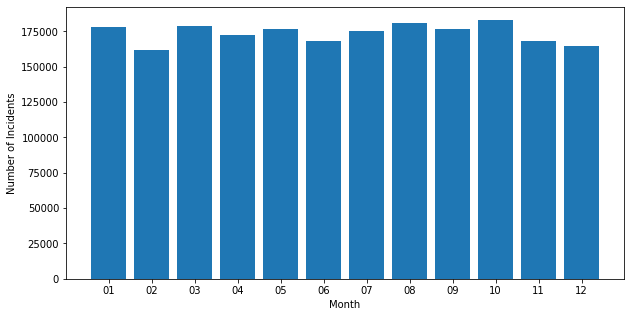

In [0]:
fig = plt.figure(figsize=(10, 5))
plt.bar(crimeMonth['Month'], crimeMonth['Count'])
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.show()

There are not much difference in a year, only a bit less crimes in Feb, Jun, Nov, and Dec compare to other months in a year.

####Travel Suggestion with respect to the hour in certian day.

In [0]:
crimeTime = spark.sql('select left(Date, 5) as Date, left(Time, 2) as Hour from sf_crime')
crimeTime = crimeTime.toPandas()
crimeTime.Date = crimeTime.Date.map(lambda x: x.split('/')[0] + '-' + x.split('/')[1])
crimeTime['Hour'] = crimeTime['Hour'].astype(float)

# Create a function to extract certain day and plot the crimes respect to the hour in the day.
def crimeHour(date):
  df = crimeTime[crimeTime['Date'] == date]
  df = df.groupby(['Hour']).size().reset_index(name='counts')
  fig = plt.figure(figsize=(10,5))
  plt.bar(df['Hour'], df['counts'])
  plt.xlabel('Time of the day')
  plt.ylabel('Number of Incidents from 2003 to 2018 on ' + str(date))
  plt.xticks(np.arange(0,24))
  plt.show()

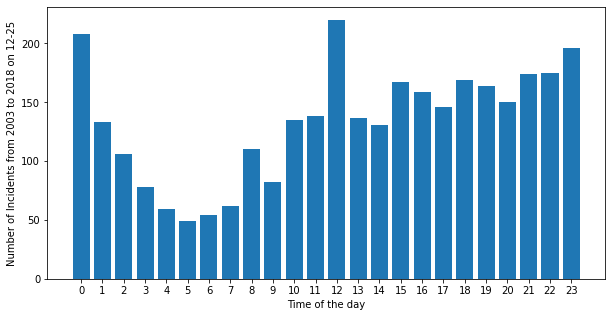

In [0]:
# For example, if you want to trave SF on Christmas, calling the function crimeHour will return the number of crimes respect to hour on Christmas in the previous year.
crimeHour('12-25')

####Count the number of crimes for different district and apply spatial distribtion with longitude and latitude information to visualize the result

In [0]:
crimeDistrict = spark.sql('select PdDistrict, count(*) as Count from sf_crime group by PdDistrict order by 2 desc')
crimeDistrict = crimeDistrict.toPandas()
crimeDistrict

Out[231]:

,PdDistrict,Count
0,SOUTHERN,390692
1,MISSION,288985
2,NORTHERN,266435
3,CENTRAL,221923
4,BAYVIEW,205480
5,TENDERLOIN,186954
6,INGLESIDE,181092
7,TARAVAL,155461
8,PARK,119698
9,RICHMOND,112804


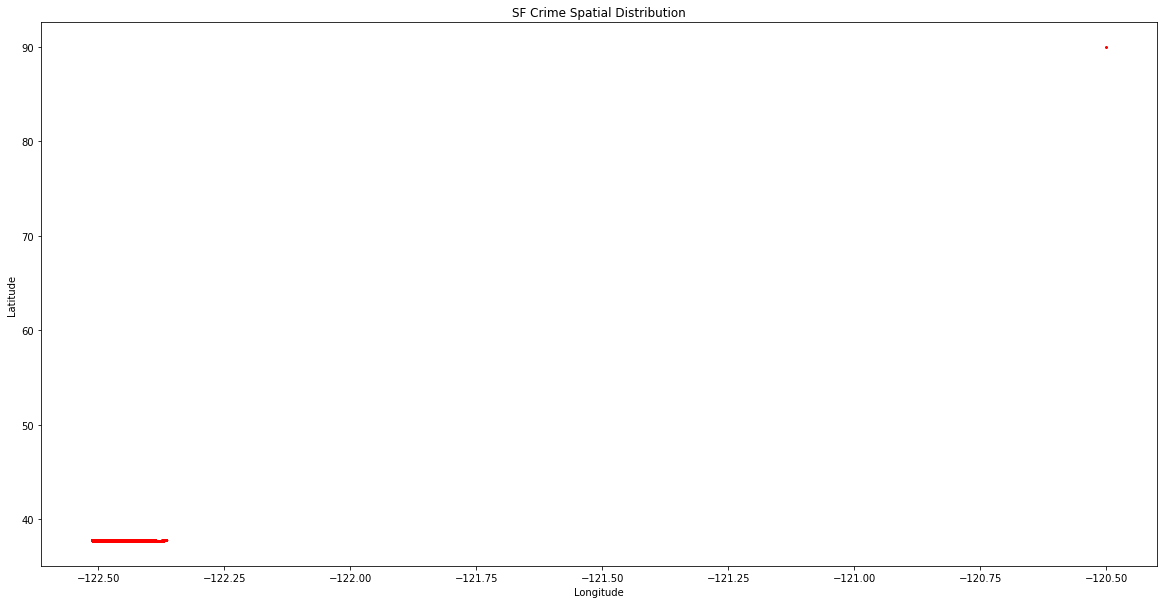

In [0]:
# Plot the locations of each incident.
crimeGeo = spark.sql('select X as Lon, Y as Lat, Date from sf_crime')
crimeGeo = crimeGeo.toPandas()
crimeGeo[['Lon','Lat']] = crimeGeo[['Lon','Lat']].astype(float)
fig = plt.figure(figsize=(20,10))
plt.title('SF Crime Spatial Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(crimeGeo.Lon, crimeGeo.Lat, s = 0.3, c = 'r')
plt.show()

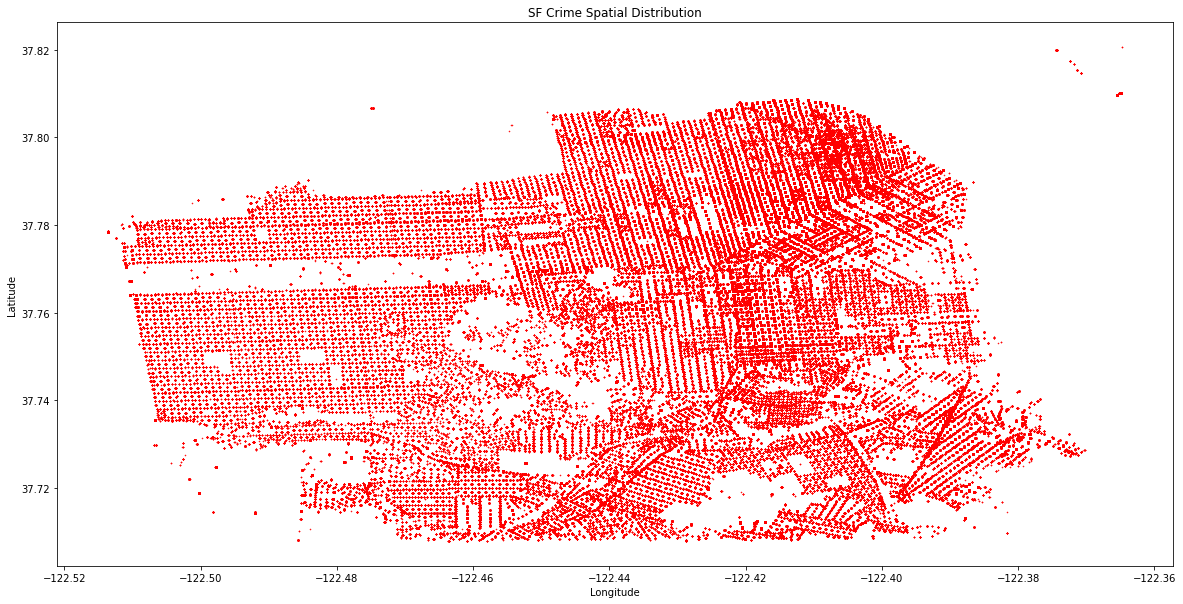

In [0]:
# Based on the plot above, there is an outlier can affect the result. Aftering removing the outlier, the plot will output as below.
crimeGeo = crimeGeo[crimeGeo['Lat'] < 40]
fig = plt.figure(figsize=(20,10))
plt.title('SF Crime Spatial Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(crimeGeo.Lon, crimeGeo.Lat, s = 0.3, c = 'r')
plt.show()

In [0]:
# Import the current police district.
def download_file(url):
  filename = url.split('/')[-1] 
  response = urllib.request.urlopen(url)
  content = response.read()
  with open(filename, 'wb' ) as f:
      f.write( content )  
  return filename

sfpd = download_file("https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=GeoJSON")
assert(os.path.exists(sfpd))
sfpd = gpd.read_file(sfpd)
display(sfpd)

,shape_area,shape_leng,company,shape_le_1,district,geometry
0,91344142.1925,87550.2751419,B,100231.353916,SOUTHERN,"MULTIPOLYGON (((-122.39186 37.79425, -122.3917..."
1,201384622.317,163013.798332,C,144143.480351,BAYVIEW,"MULTIPOLYGON (((-122.38098 37.76480, -122.3810..."
2,80623839.7922,40152.783389,D,40518.8342346,MISSION,"MULTIPOLYGON (((-122.40954 37.76932, -122.4086..."
3,82781685.5603,56493.858208,E,50608.3103205,NORTHERN,"MULTIPOLYGON (((-122.43379 37.80793, -122.4337..."
4,11072154.5623,12424.2689691,J,18796.7841847,TENDERLOIN,"MULTIPOLYGON (((-122.40217 37.78626, -122.4171..."
5,55950268.8396,64025.1290733,A,67686.5228649,CENTRAL,"MULTIPOLYGON (((-122.42612 37.80684, -122.4261..."
6,84878956.0842,46307.7769684,F,50328.9132939,PARK,"MULTIPOLYGON (((-122.43956 37.78314, -122.4383..."
7,137964024.157,69991.465355,G,75188.6283612,RICHMOND,"MULTIPOLYGON (((-122.44127 37.79149, -122.4406..."
8,193580502.155,74737.9362951,H,74474.1811635,INGLESIDE,"MULTIPOLYGON (((-122.40450 37.74858, -122.4040..."
9,284676677.833,75350.2175209,I,73470.4240002,TARAVAL,"MULTIPOLYGON (((-122.49842 37.70810, -122.4984..."


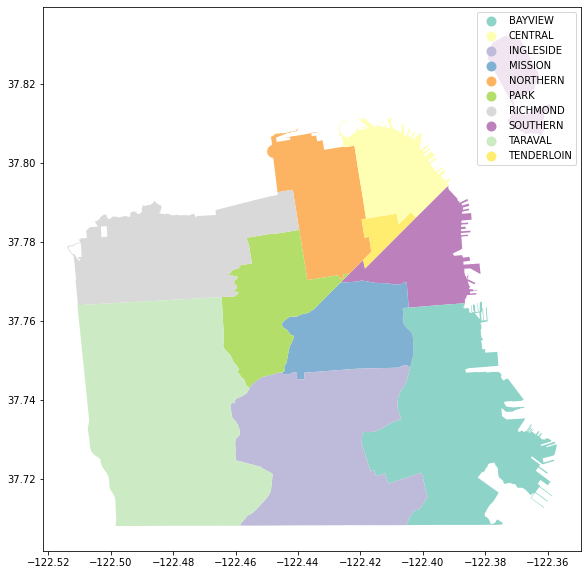

In [0]:
plot = sfpd.plot(figsize=(20,10), column = 'district', cmap='Set3', legend = True)
display(plot)

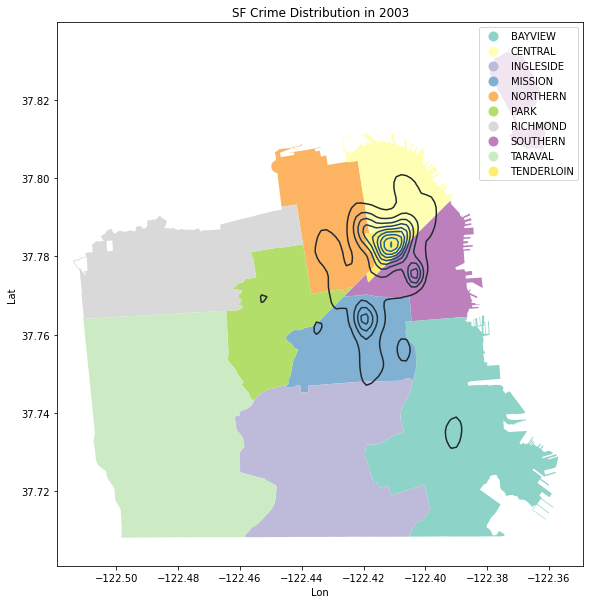

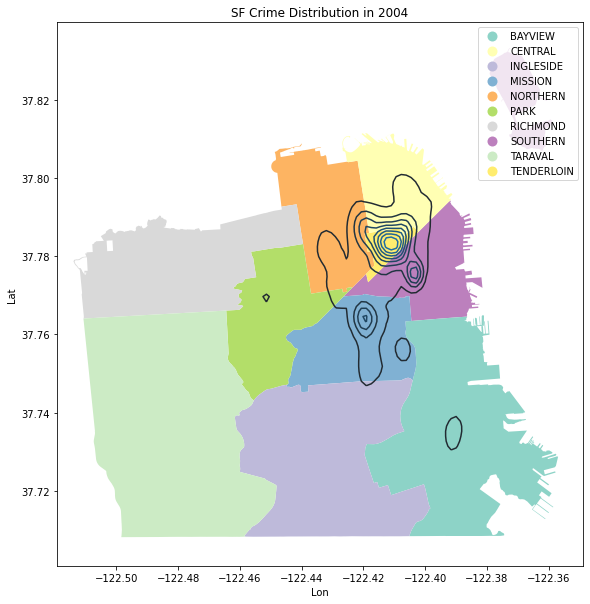

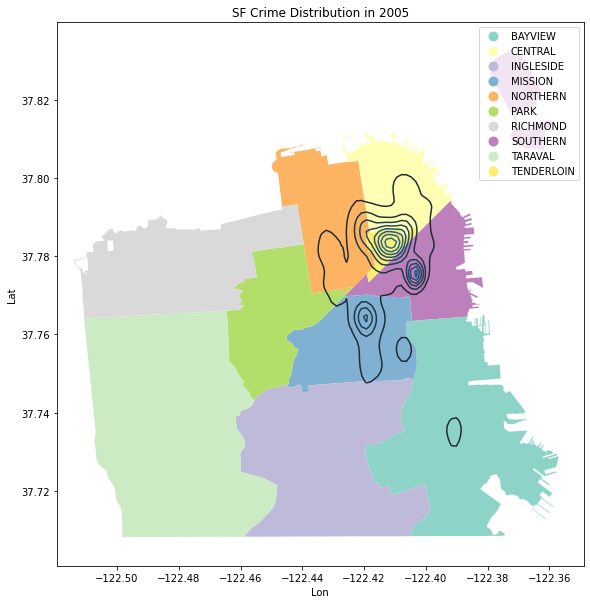

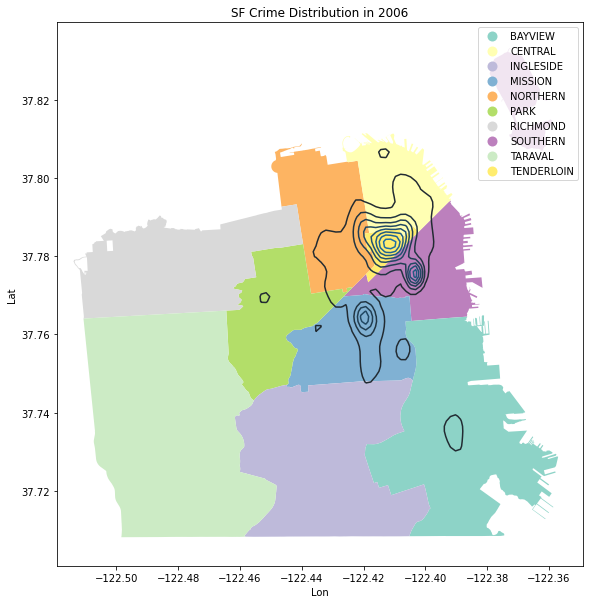

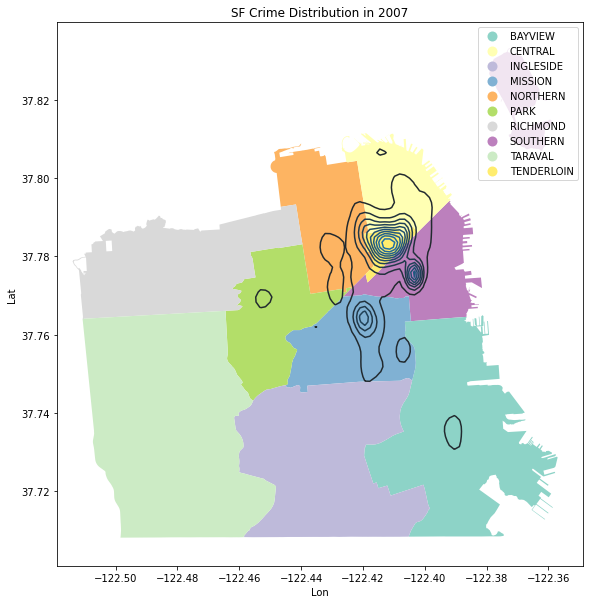

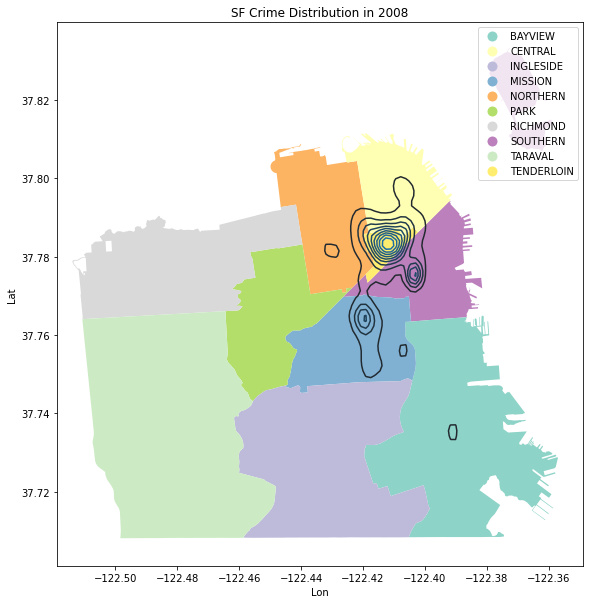

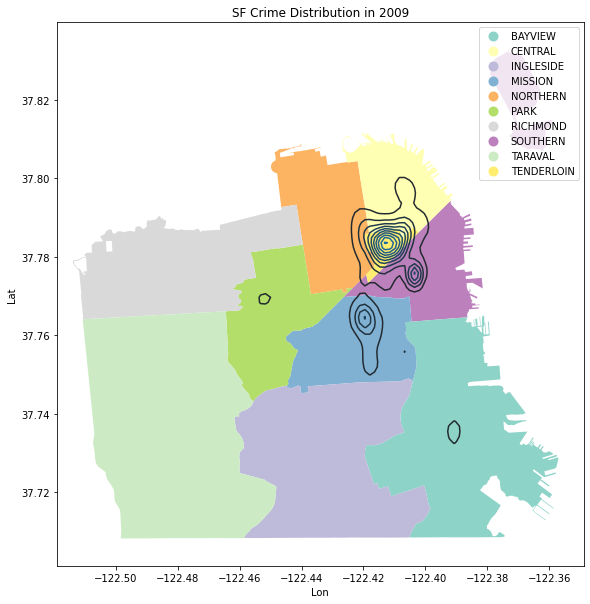

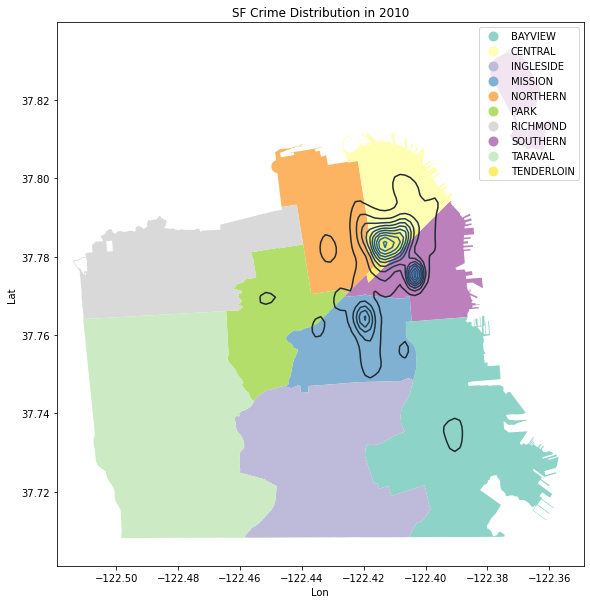

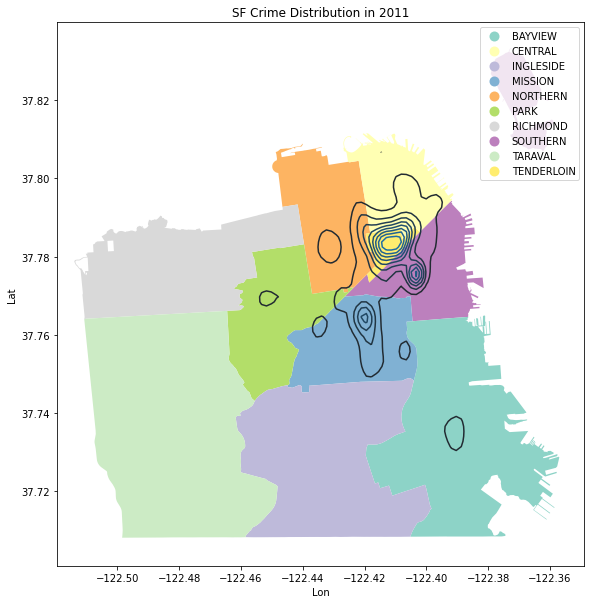

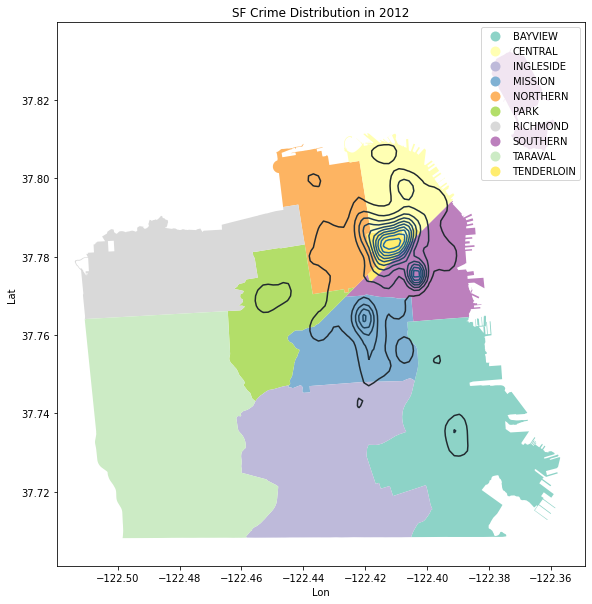

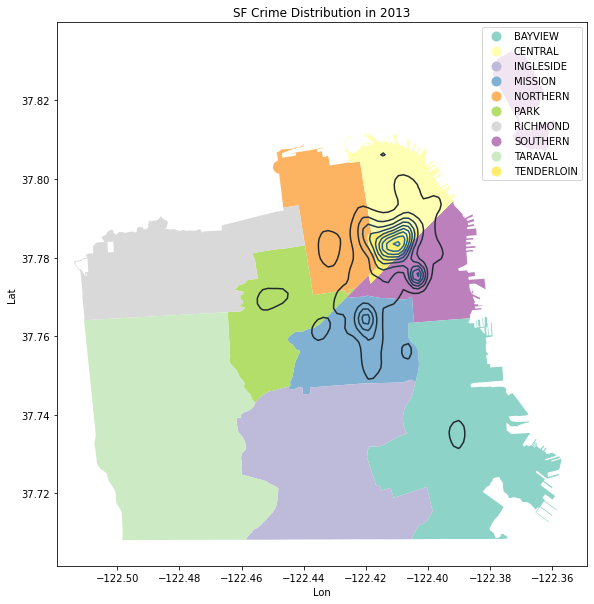

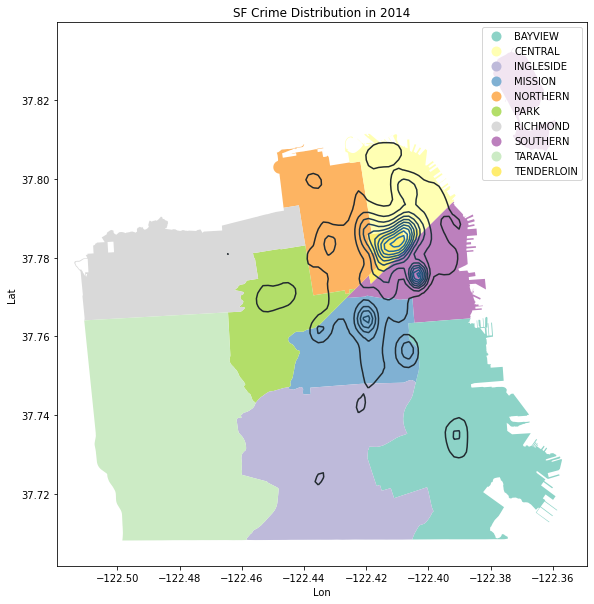

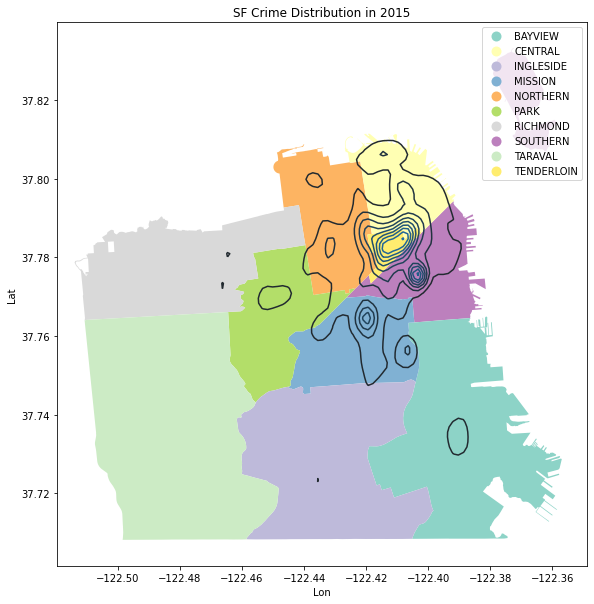

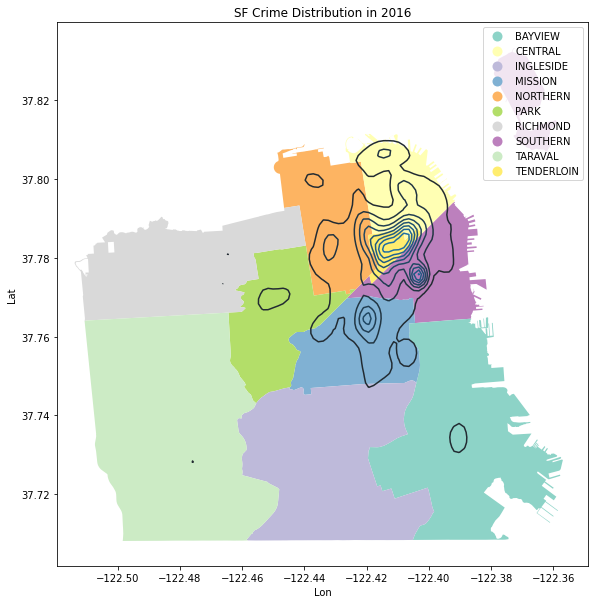

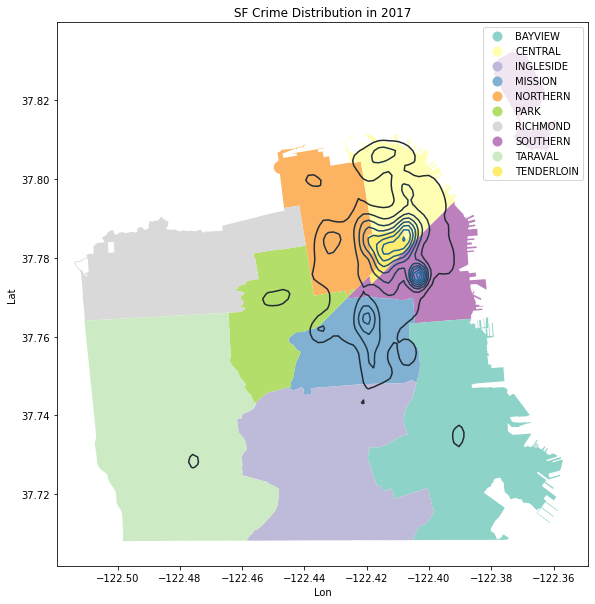

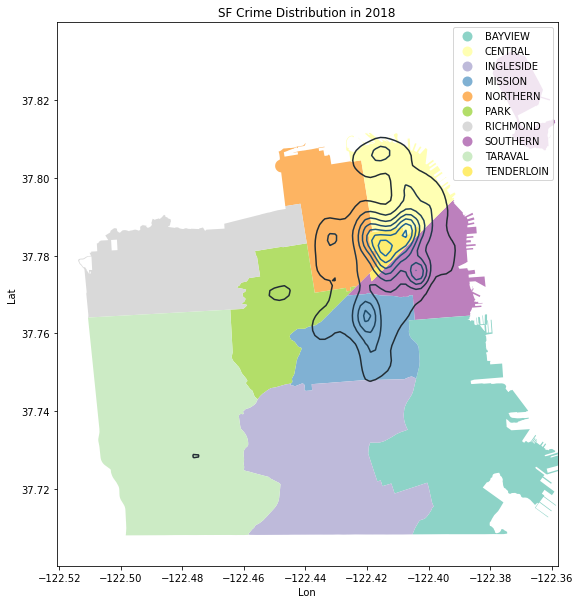

In [0]:
# As we know, the north eastern part of SF includes the districts of southern, mission, northern, and central has more cimes.
# Then, I would like to overlap contours on the SF map to how the crime locations change every year.
crimeGeo.Date = crimeGeo.Date.map(lambda x: x.split('/')[2] + '-' + x.split('/')[0] + '-' + x.split('/')[1])
for y in range(2003, 2019):
  df_year = crimeGeo[(crimeGeo['Date'] < str(y+1) + '-01') & (crimeGeo['Date'] > str(y-1) + '-12-31')]
  fig, ax = plt.subplots(1, figsize=(20,10))
  plt.title('SF Crime Distribution in ' + str(y))
  sfpd_map = sfpd.plot(ax=ax, column = 'district', cmap='Set3', legend = True)
  sns.kdeplot(df_year['Lon'], df_year['Lat'], ax = sfpd_map)
  plt.show()

Based on the distribution of crime locations for each year, we can see that the north eastern part of SF is always the dangerous part of SF since 2003.

####Time Series

Out[211]:

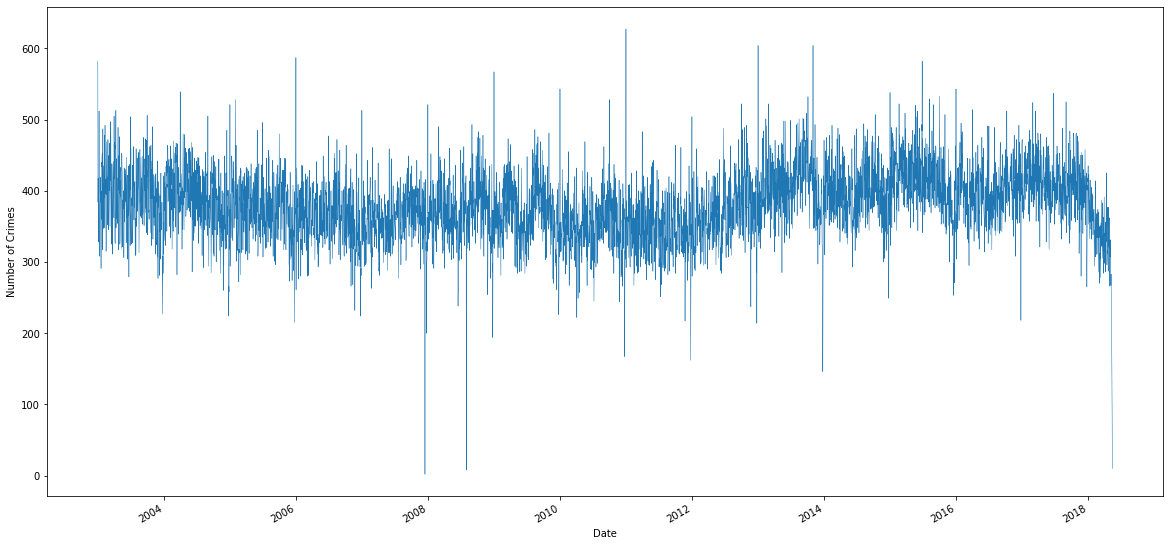

Text(0, 0.5, 'Number of Crimes')

In [0]:
crimeSeries = spark.sql('select Date, count(*) as Count from sf_crime group by 1')
crimeSeries = crimeSeries.toPandas()
crimeSeries.Date = crimeSeries.Date.map(lambda x: x.split('/')[2] + '-' + x.split('/')[0] + '-' + x.split('/')[1])
crimeSeries['Date'] = pd.to_datetime(crimeSeries.Date)
crimeSeries.sort_values(by=['Date'])
crimeSeries = crimeSeries.set_index('Date')
fig = plt.figure(figsize=(20,10))
crimeSeries['Count'].plot(linewidth=0.5)
plt.ylabel('Number of Crimes')

From the plot above, there is no much difference over these years.

### Conclusion
In this San Francisco crime data analysis from 2013 to 2018, I generated insight from data in San Francisco Police website which including category, date, districts, and location to help us identify the specific place in Seattle by using Spark, Spark SQL, and Pandas. In the process of data visualization, I used python package Matplotlib and Seaborn. In this project, I realized that the speed of loading dataset and data manipulation using Spark is much faster than using Python Pandas.

Based on what I discover in this dataset, the most crime category is larceny/theft which is more than 478 thousand, and the most dangarous district in SF is the Southern district. Accounting to the spatial distribution, we see that most of the crimes are at the north eastern part of SF and now this area has expanded a bit toward the weat and south part of SF. Moreover, with the time series distribution, it shows the number of crimes do not decrease in these years. Hence, if you would like to travel SF, I would suggest that you visit in February which has the least crime of the year, also do not visit the north eastern part of SF to reduce the incidence of criminals.